### Relevant links

https://www.kaggle.com/c/competitive-data-science-predict-future-sales


Also in this notebook, I am trying to change how features are generated in the v0 version, Here I will not fix the training month to only one month but rather use all data points and take lags. Will take out of time sample as a validation dataset but training will have data from any number of months

### Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 147 ms


In [1]:
from scripts.imports import *
import scripts.kaggle_data as kd
from scripts.utility import *
from scripts.utility_v1 import *

In [4]:
pd.options.display.max_rows = 4000
pd.set_option('display.max_columns', 999)
pd.options.mode.chained_assignment = None

time: 25 ms


### Getting data

In [ ]:
current_path = os.getcwd()
data_dir_path = os.path.join(current_path,"data")

if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

print(data_dir_path) #Never print

In [ ]:
kd.download_data('competitive-data-science-predict-future-sales',current_path)

In [5]:
#Listify files to download
all_data_files = os.listdir('data/') #Getting all files in data folder in a list
all_data_files = [x for x in all_data_files if x.endswith('.csv')] #Removing .ipynb files
all_data_files = [remove_from_right(x,4) for x in all_data_files] #Removing .csvs
all_data_files

['shops',
 'items',
 'submission_v1',
 'item_categories',
 'sales_train',
 'sample_submission',
 'test']

time: 154 ms


In [6]:
for i in all_data_files:
    print(i + "=" + f"kd.read_data('data/','csv','{i}')")
    print("")
    exec(i + "=" + f"kd.read_data('data/','csv','{i}')")
    exec(f"shape = {i}.shape")
    print(f"Shape of {i}: ", shape)
    exec(f"data_types = {i}.dtypes")
    print("")
    print(f"Data types in {i}: \n \n ", data_types)
    print("---------------------")

shops=kd.read_data('data/','csv','shops')

Shape of shops:  (60, 2)

Data types in shops: 
 
  shop_name    object
shop_id       int64
dtype: object
---------------------
items=kd.read_data('data/','csv','items')

Shape of items:  (22170, 3)

Data types in items: 
 
  item_name           object
item_id              int64
item_category_id     int64
dtype: object
---------------------
submission_v1=kd.read_data('data/','csv','submission_v1')

Shape of submission_v1:  (214200, 2)

Data types in submission_v1: 
 
  ID                  int64
item_cnt_month    float64
dtype: object
---------------------
item_categories=kd.read_data('data/','csv','item_categories')

Shape of item_categories:  (84, 2)

Data types in item_categories: 
 
  item_category_name    object
item_category_id       int64
dtype: object
---------------------
sales_train=kd.read_data('data/','csv','sales_train')

Shape of sales_train:  (2935849, 6)

Data types in sales_train: 
 
  date               object
date_block_num  

In [7]:
save_test = test

time: 18 ms


### Testing data

#### Structural checks

In [ ]:
#Unique data values
#sales_train >> \
#select(X.date,X.date_block_num) >> \
#distinct(X.date,X.date_block_num) >> \
#arrange(X.date_block_num, ascending = True) 

#Finding
#We have daily sales data as well

In [ ]:
#Check for missing value in train data
#for k in sales_train.columns:
    #display_all(sales_train >> summarise_each([null_percent],k))

#### See headers of all data

In [ ]:
sales_train >> head

In [ ]:
shops >> head

In [ ]:
items >> head

In [ ]:
item_categories >> head

In [ ]:
test >> head

### Feature engineering

#### Create features

In [8]:
# Add dates to training data
sales_train = add_datepart(df = sales_train, custom_date_format = '%d.%m.%Y',field_name = 'date', drop = False)
#Assignment is done to avoid printing the dataframe
raw_data = sales_train

time: 10.3 s


In [148]:
raw_data = raw_data >> mutate(item_id = X.item_id.astype(str), shop_id = X.shop_id.astype(str)) >> \
mutate(item_cnt_day = if_else(X.item_cnt_day < 0, 0, X.item_cnt_day),
      item_cnt_day_return = if_else(X.item_cnt_day < 0, -X.item_cnt_day,0))

time: 4.46 s


In [151]:
#raw_data >> select(X.date_block_num,X.Month,X.Year) >> \
#distinct(X.date_block_num,X.Month,X.Year) >> arrange(X.date_block_num)
#Will use date block num as a unique month idetifier from now on

time: 31.1 ms


In [213]:
#Compute monthly metrics
#Price changes 
#number of purchases
#Translate everything daily to monthly

raw_data_month = raw_data >> mask((X.date_block_num >= train_month -32) & (X.date_block_num <= train_month) ) >> \
mutate(date_flag = if_else(X.date_block_num == train_month,'y','x'))

time: 10.4 s


In [214]:
#Start creating lag variables for everything and then merge with test data to attach the features

(417004, 4)
(408799, 4)
(214200, 3)
time: 6.78 s


In [2]:
#Create new features from the lag features

In [218]:
#Add item presence (Think how to add lag varables for this)

time: 1min 24s


In [3]:
#Item category size at each time point

In [4]:
#Now generate train, valid and test DFs

### EDA

#### Check distribution

In [163]:
check = dd_summarise(raw_data,['date_block_num','item_id','shop_id'],'item_cnt_day','sum')

time: 3.84 s


In [167]:
check[check.item_cnt_day > 20].shape[0]/check.shape[0]

0.0071312092790860124

time: 28 ms


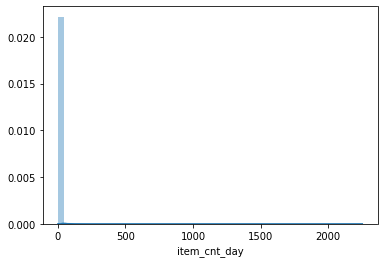

time: 735 ms


In [228]:
sns.distplot(check.item_cnt_day[check.item_cnt_day>0])

### Modelling

#### Xgboost

In [301]:
##data preparation
ind_columns = train.columns.to_list()

list_to_remove = ['shop_id','item_id','item_cnt_day']
ind_columns = remove_elements(ind_columns, list_to_remove )

dep_coloumns = ["item_cnt_day"]

cont_vars = train.head(5).select_dtypes(include= [np.number]).columns.to_list()
cont_vars = remove_elements(cont_vars, ['item_cnt_day'])

cat_vars = train.head(5).select_dtypes(include= [object]).columns.to_list()
list_to_remove = ['shop_id','item_id']

cat_vars = remove_elements(cat_vars, list_to_remove)

train_sampled = train #>> sample(50000)

x_train = train_sampled[ind_columns]
y_train = train_sampled[dep_coloumns]

x_test = test[ind_columns]

x_valid = valid[ind_columns]
y_valid = valid[dep_coloumns]

print("Shape of training data: ", x_train.shape)
print("Shape of validation data: ", x_valid.shape)
print("Shape of test data: ", x_test.shape)

xg_train = xgb.DMatrix(x_train, label = y_train)
xg_test = xgb.DMatrix(x_test)
xg_valid = xgb.DMatrix(x_valid, label = y_valid)

Shape of training data:  (417004, 91)
Shape of validation data:  (408799, 91)
Shape of test data:  (214200, 91)
time: 3.14 s


In [5]:
# #Model
# param = {'max_depth':8,
#          'eta':0.05, # learning rate
#          'gamma':2,
#          'min_child_weight':10,
#          'objective':'reg:squarederror',
#          'eval_metric': 'rmse' ,
#          'colsample_bytree': 0.6}

# watchlist  = [(xg_valid, 'valid')]
# num_round = 1000

# xgm = xgb.train(param, xg_train, num_round, evals = watchlist, early_stopping_rounds=10)

In [6]:
#my_plot_importance(xgm,(20,50),importance_type='gain')

In [7]:
#RMSE in validation data
#rmse(xgm.predict(xg_valid),y_valid.values.ravel())

In [8]:
#RMSE in train data
#rmse(xgm.predict(xg_train),y_train.values.ravel())

In [9]:
# valid_predictions = xgm.predict(xg_valid)
# valid_predictions = valid >> mutate(item_cnt_day_predicted = valid_predictions) >> \
# mutate(errors = (X.item_cnt_day - X.item_cnt_day_predicted))

# vp = valid_predictions

# sns.distplot(vp.item_cnt_day - vp.item_cnt_day_predicted)

### Submission

#### XGBoost

In [306]:
test_predictions = xgm.predict(xg_test)
test_predictions.shape

(214200,)

time: 214 ms


In [307]:
test_submission = save_test >> mutate(item_cnt_day = test_predictions)
test_submission = test_submission >> rename(item_cnt_month = X.item_cnt_day) >> drop(X.item_id,X.shop_id)

time: 45.1 ms


In [10]:
#test_submission.to_csv('data/submission__xgb_vx.csv', index=False)

### Unit tests